In [1]:
import os
import sys
import cv2
import PIL
import glob
import time
import random
import imageio
import sklearn
import itertools
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.mixed_precision import experimental as mixed_precision

from label_utils import get_labels

K.clear_session()
physical_devices = tf.config.experimental.list_physical_devices("GPU")

def enable_amp():
    policy = mixed_precision.Policy("mixed_float16")
    mixed_precision.set_policy(policy)
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices)
enable_amp()

Tensorflow version:  2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'segmentation': tf.io.FixedLenFeature((), tf.string),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'image_depth': tf.io.FixedLenFeature((), tf.int64),
        'mask_depth': tf.io.FixedLenFeature((), tf.int64),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    image = tf.io.parse_tensor(example['image'], out_type = tf.uint8)
    image_shape = [example['height'], example['width'], 3]
    image = tf.reshape(image, image_shape)
    
    mask = tf.io.parse_tensor(example['segmentation'], out_type = tf.uint8)
    mask_shape = [example['height'], example['width'], 1]
    mask = tf.reshape(mask, mask_shape)
    
    return image, mask


def get_dataset_from_tfrecord(tfrecord_dir):
    tfrecord_dataset = tf.data.TFRecordDataset(tfrecord_dir)
    parsed_dataset = tfrecord_dataset.map(read_tfrecord)
    return parsed_dataset

In [3]:
train_tfrecord_dir = 'Cityscapes\\train.tfrecords'
test_tfrecord_dir = 'Cityscapes\\test.tfrecords'

img_height = 256
img_width = 512
n_classes = 34

labels = get_labels()
id2label = { label.id : label for label in labels }

In [4]:
@tf.function
def mask_to_categorical(image, mask):
    mask = tf.squeeze(mask)
    mask = tf.one_hot(tf.cast(mask, tf.int32), n_classes)
    mask = tf.cast(mask, tf.float32)
    return image, mask


@tf.function
def load_image_train(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask

def load_image_test(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask

In [5]:
TRAIN_LENGTH = 2780
TEST_LENGTH = 695
BATCH_SIZE = 4
BUFFER_SIZE = 800

In [6]:
train_tfrecords_dataset = get_dataset_from_tfrecord(train_tfrecord_dir)
test_tfrecords_dataset = get_dataset_from_tfrecord(test_tfrecord_dir)

In [7]:
# Preprocessing: resize the images and masks, flip them, and normalize them
train = train_tfrecords_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_tfrecords_dataset.map(load_image_test)

In [8]:
# the cache() transformation reduces resource usage
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [9]:
def label_to_rgb(mask):
    mask_rgb = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    for i in range(0,n_classes):
        mask_rgb[mask[:,:,0]==i] = id2label[i].color
    return mask_rgb


def display(display_list, title=False):
    plt.figure(figsize=(15, 7))
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

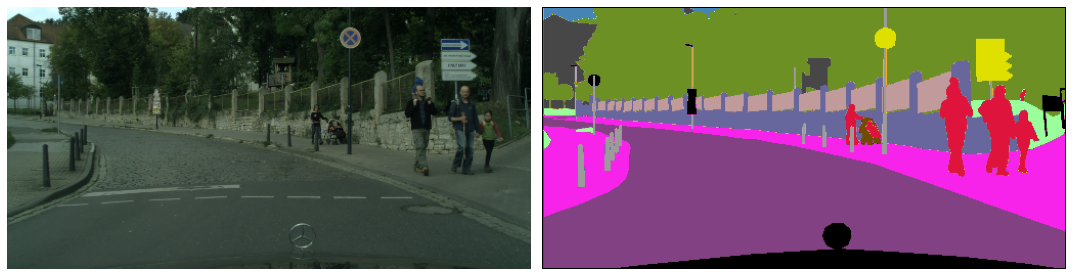

In [10]:
for image, mask in test.take(13):
    sample_image, sample_mask = image, mask
    
sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [11]:
def unet_model(input_height=img_height,  input_width=img_width, n_classes = 3):
    
    img_input = tf.keras.layers.Input(shape=(input_height, input_width, 3))

    # -------------------------- Encoder --------------------------
    
    c1 = Conv2D(64, 3, padding='same', activation="selu")(img_input)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, 3, padding='same', activation="selu")(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(128, 3, padding='same', activation="selu")(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, 3, padding='same', activation="selu")(c2)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(0.1)(p2)
    
    c3 = Conv2D(256, 3, padding='same', activation="selu")(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, 3, padding='same', activation="selu")(c3)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(0.2)(p3)
    
    c4 = Conv2D(512, 3, padding='same', activation="selu")(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, 3, padding='same', activation="selu")(c4)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(0.3)(p4)
    
    # ------------------------ Bottleneck -------------------------
    
    c5 = Conv2D(1024, 3, padding='same', activation="selu")(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, 3, padding='same', activation="selu")(c5)
    c5 = Dropout(0.5)(c5)
    
    # -------------------------- Decoder --------------------------
    
    u6 = concatenate([UpSampling2D(2)(c5), c4])
    c6 = Conv2D(512, 3, padding='same', activation='selu')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(256, 3, padding='same', activation='selu')(c6)
    c6 = Dropout(0.3)(c6)
    
    u7 = concatenate([UpSampling2D(2)(c6), c3])
    c7 = Conv2D(256, 3, padding='same', activation='selu')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(128, 3, padding='same', activation='selu')(c7)
    c7 = Dropout(0.2)(c7)

    u8 = concatenate([UpSampling2D(2)(c7), c2])
    c8 = Conv2D(128, 3, padding='same', activation='selu')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(64, 3, padding='same', activation='selu')(c8)
    c8 = Dropout(0.1)(c8)

    u9 = concatenate([UpSampling2D(2)(c8), c1]) 
    c9 = Conv2D(64, 3, padding='same', activation='selu')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, 3, padding='same')(u9)
    c9 = Activation('selu')(c9)
    c9 = Conv2D(n_classes, 3, padding='same')(c9)
    
    output = Activation("softmax", dtype='float32')(c9)
    
    return tf.keras.Model(inputs=img_input, outputs=output)

In [12]:
def dice_coef(y_true, y_pred):
    dice = 0.0
    smooth = 1.0
    for i in range(1, n_classes):
        intersection = y_true[:,:,i] * y_pred[:,:,i]
        all_ = y_true[:,:,i] + y_pred[:,:,i]
        intersection = K.sum(intersection, 1)
        all_ = K.sum(all_, 1)
        temp = (2. * intersection + smooth) / (all_ + smooth)
        temp = K.mean(temp)
        dice = dice + temp
    return dice / (n_classes-1)


def cce_dice_loss(y_true, y_pred):
    return (tf.keras.losses.categorical_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)) + 1

In [13]:
model = unet_model(input_height=img_height, input_width=img_width, n_classes=34)

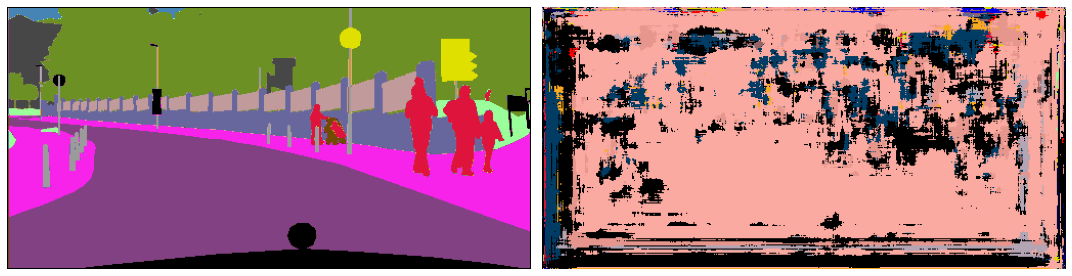

In [14]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    # display([sample_image, sample_mask, create_mask(pred_mask)])
    display([sample_mask, create_mask(pred_mask)])

        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        
show_predictions()

In [15]:
model_name = "saved_models\\unet_cityscapes.h5"

model.compile(
    optimizer = Adam(lr=1e-4),
    loss = cce_dice_loss, #"categorical_crossentropy", 
    metrics = ['accuracy', dice_coef]
)

callbacks = [
    DisplayCallback(),
    EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_dice_coef', mode='max', patience=2, factor=0.1, min_lr=1e-10, verbose=1),
    ModelCheckpoint(model_name, monitor='val_dice_coef', verbose=1, mode='max', save_best_only=True, save_weights_only=True)
]
# model.load_weights("big_unet_model.h5", by_name=True)

In [16]:
EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE

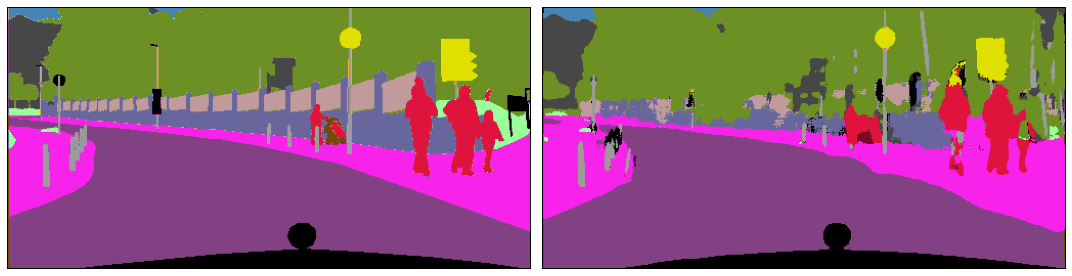


Sample Prediction after epoch 14


Epoch 00014: val_dice_coef did not improve from 0.90457
695/695 [==============================] - 192s 276ms/step - loss: 0.5550 - accuracy: 0.8758 - dice_coef: 0.9060 - val_loss: 0.5691 - val_accuracy: 0.8738 - val_dice_coef: 0.9045
Epoch 15/100
537/695 [======================>.......] - ETA: 38s - loss: 0.5524 - accuracy: 0.8762 - dice_coef: 0.9066

In [ ]:
results = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs = EPOCHS,
    validation_data = test_dataset,
    callbacks = callbacks,
    verbose = 1
)

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)  
plt.plot(results.history['loss'], 'r', label='Training loss')
plt.plot(results.history['val_loss'], 'b', label='Validation loss')
plt.title('Log Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('log_loss', fontsize=16)
# plt.ylim([0, 1])
plt.legend()

plt.subplot(1,3,2)
plt.plot(results.history['accuracy'], 'r', label='Training accuracy')
plt.plot(results.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
# plt.ylim([0, 1])
plt.legend()

plt.subplot(1,3,3)
plt.plot(results.history['dice_coef'], 'r', label='Dice coefficient')
plt.plot(results.history['val_dice_coef'], 'b', label='Validation dice coefficient')
plt.title('Dice Coefficient', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Dice', fontsize=16)
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
n_samples = 100

X_test = np.zeros((n_samples, img_height, img_width, 3))
y_test = np.zeros((n_samples, img_height, img_width, n_classes))

for idx, (image, mask) in enumerate(test):
    X_test[idx] = image.numpy()
    y_test[idx] = mask.numpy()
    if idx == (n_samples-1):
        break

print("X_test.shape: {} , y_test.shape: {}".format(X_test.shape, y_test.shape))

In [ ]:
img_num = 4
sample_image = X_test[img_num]
sample_mask = np.expand_dims(np.argmax(y_test[img_num], axis=-1), axis=-1)
sample_mask = label_to_rgb(sample_mask)

def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask, axis=0)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    display([sample_mask, create_mask(pred_mask)])
    
show_predictions()

In [ ]:
y_pred = model.predict(X_test[0:n_samples])

In [ ]:
def dice_coef_eval(y_true, y_pred):
    dice = 0.0
    smooth = 1.0
    class_dice = []
    for i in range(1, n_classes):
        intersection = y_true[:,:,i] * y_pred[:,:,i]
        all_ = y_true[:,:,i] + y_pred[:,:,i]
        intersection = K.sum(intersection, 1)
        all_ = K.sum(all_, 1)
        temp = (2. * intersection + smooth) / (all_ + smooth)
        temp = K.mean(temp)
        class_dice.append(round(temp.numpy(), 4))
        dice = dice + temp
    total_dice = dice / (n_classes-1)
    return class_dice, round(total_dice.numpy(), 4)

In [ ]:
class_dice, total_dice = dice_coef_eval(y_test[0:n_samples], y_pred)

In [ ]:
print("class 1: {} \nclass 2: {} \nclass 3: {} \ntotal: {}".format(class_dice[0], class_dice[1], class_dice[2], total_dice))

In [ ]:
# around 92%